In [5]:
import numpy as np
import librosa
from matplotlib import pyplot as plt

from DistantSpeech.transform.subband import Subband
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import mesh, pmesh, pt, visual
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite

True
n_frames:421


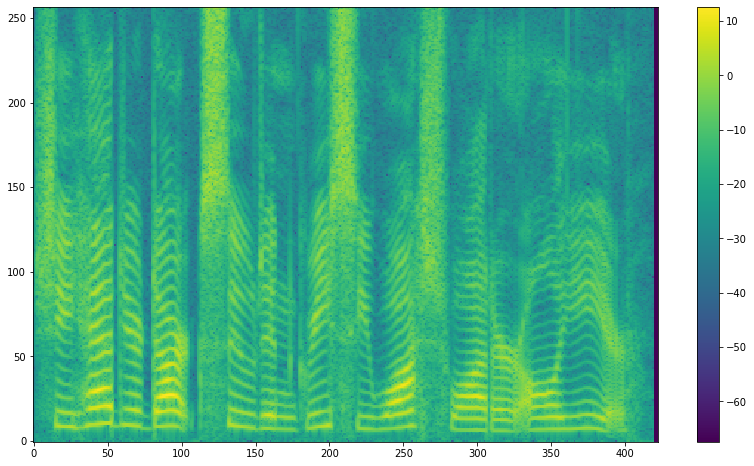

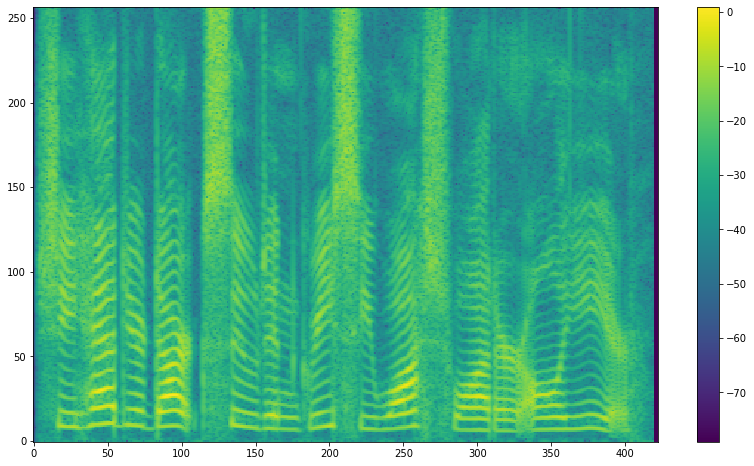

(257, 421)


In [6]:


filename = "/home/wangwei/work/DistantSpeech/DistantSpeech//transform/speech1.wav"
data, sr = librosa.load(filename, sr=None)

data_recon_stft = np.zeros(len(data))
data_recon_subband = np.zeros(len(data))
t = 0
frame_length = 128*5
stream = librosa.stream(
    filename,
    block_length=1,
    frame_length=frame_length,
    hop_length=frame_length,
    mono=True,
)

# check COLA
from scipy import signal
n_fft = 512
hop_len = 128
overlap = n_fft - hop_len
result = signal.check_COLA(signal.hann(n_fft,sym=False),n_fft,overlap)
print(result)

transform = Transform(n_fft=n_fft, hop_length=hop_len)
subband = Subband(n_fft=n_fft, hop_length=hop_len)

n_frames = int((data.shape[0]) / hop_len)
print('n_frames:{}'.format(n_frames))
mag_stft = np.zeros((257, n_frames + 2))
mag_subband = np.zeros((257, n_frames + 2))

D = int(frame_length/hop_len)

# streaming demo
for y_block in stream:
    if len(y_block) >= frame_length:
        D_stft = transform.stft(y_block)  # [half_bin, n_frame, channel]
        mag_stft[:, t*D:t*D+D_stft.shape[1]] = np.abs(D_stft[..., 0])
        d = transform.istft(D_stft)
        data_recon_stft[t * frame_length : (t + 1) * frame_length] = d

        D_sb = subband.analysis(y_block)  # [half_bin, n_frame, channel]
        mag_subband[:, t*D:t*D+D_stft.shape[1]] = np.abs(D_sb)
        d = subband.synthesis(D_sb)
        data_recon_subband[t * frame_length : (t + 1) * frame_length] = d
              
    t = t + 1
pmesh(librosa.power_to_db(mag_stft))
pmesh(librosa.power_to_db(mag_subband))

# batch demo
D = subband.analysis(data)
print(D.shape)
# pmesh(librosa.power_to_db(np.abs(D)))
# pt(data_recon_subband)


In [7]:
print(np.sum(np.abs(data)))
print(np.sum(np.abs(data_recon_subband)))
print(np.sum(np.abs(data_recon_subband))/np.sum(np.abs(data)))

764.38367
764.2382524939002
0.9998097624209326


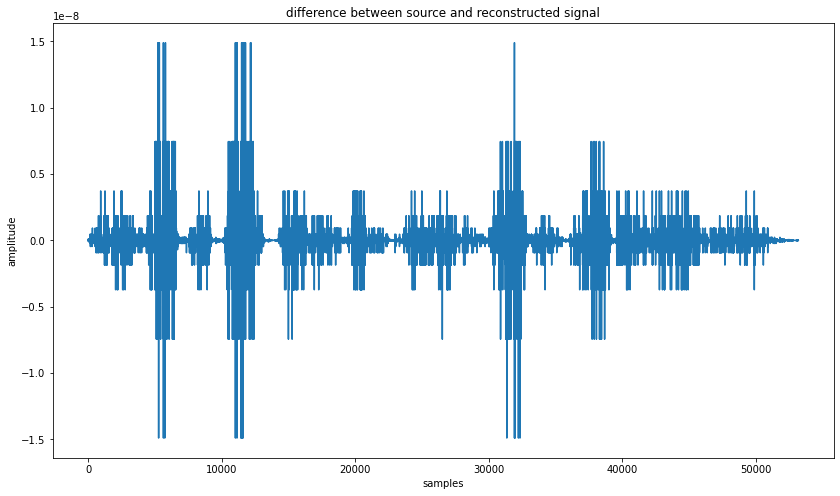

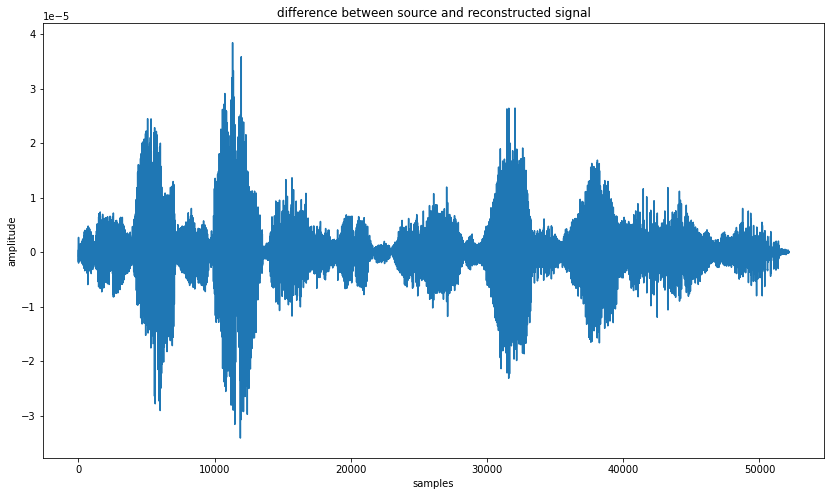

In [8]:

# compare difference between original signal and reconstruction signal
plt.figure(figsize=(14,8))
plt.plot(data[: len(data_recon_stft[transform.overlap:-transform.overlap])] - data_recon_stft[transform.overlap:-transform.overlap])
plt.title("difference between source and reconstructed signal")
plt.xlabel("samples")
plt.ylabel("amplitude")
plt.show()

plt.figure(figsize=(14,8))
plt.plot(data[: len(data_recon_subband[subband.overlap:-subband.overlap])] - data_recon_subband[subband.overlap:-subband.overlap])
plt.title("difference between source and reconstructed signal")
plt.xlabel("samples")
plt.ylabel("amplitude")
plt.show()

audiowrite('data_recon_subband.wav', data_recon_subband)